In [1]:
!pwd

/home/jupyter/NamikawaLab2019/DCGAN-TF2.0


In [2]:
%load_ext tensorboard

In [3]:
!pip install -q imageio --user
!pip install -q tqdm --user

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [5]:
import tensorflow as tf
from tensorflow.keras import layers
print('TensorFlow Version: {}'.format(tf.__version__))

TensorFlow Version: 2.0.0


In [6]:
import datetime
import glob
import os
import random
import time
from pathlib import Path

import imageio
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import PIL
from tqdm import tqdm

In [7]:
color_channel = 3
fr = 64  # final resolution
h_fr = int(fr / 2)  # half of final resolution
q_fr = int(fr / 4)  # quarter of final resolution
noise_dim = 100
num_examples_to_generate = 16

BATCH_SIZE = 256
EPOCHS = 10
AUTOTUNE = tf.data.experimental.AUTOTUNE

now = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

data_root = Path('/mnt/dataset/wabisabi')
checkpoints_dir = './checkpoints'
epochs_dir = './epochs'
gifs_dir = './gifs'
logs_dir = './logs'

In [8]:
!rm -rf $checkpoints_dir
!mkdir -p $checkpoints_dir
!rm -rf $epochs_dir
!mkdir -p $epochs_dir
!mkdir -p $gifs_dir
!rm -rf $logs_dir
!mkdir -p $logs_dir
!ls -la

total 184
drwxr-xr-x 7 jupyter jupyter   4096 Jan  6 18:21 .
drwxr-xr-x 8 jupyter jupyter   4096 Jan  6 12:32 ..
drwxr-xr-x 2 jupyter jupyter   4096 Jan  6 18:21 checkpoints
-rw-r--r-- 1 jupyter jupyter  36577 Jan  6 05:15 DCGAN-TF2.0-MNIST.ipynb
-rw-r--r-- 1 jupyter jupyter 121020 Jan  6 18:21 DCGAN-TF2.0-wabisabi.ipynb
drwxr-xr-x 2 jupyter jupyter   4096 Jan  6 18:21 epochs
drwxr-xr-x 3 jupyter jupyter   4096 Jan  6 16:38 gifs
drwxr-xr-x 2 jupyter jupyter   4096 Jan  5 04:33 .ipynb_checkpoints
drwxr-xr-x 2 jupyter jupyter   4096 Jan  6 18:21 logs


In [9]:
train_summary_writer = tf.summary.create_file_writer(logs_dir)
history = {'train_loss': []}

In [10]:
(mnist_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
print('MNIST Images Shape: {}'.format(mnist_images.shape))
mnist_images = mnist_images.reshape(mnist_images.shape[0], 28, 28, 1).astype('float32')
mnist_images = (mnist_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
mnist_dataset = tf.data.Dataset.from_tensor_slices(mnist_images).shuffle(len(mnist_images)).batch(BATCH_SIZE)
print('MNIST Dataset: {}'.format(mnist_dataset))

MNIST Images Shape: (60000, 28, 28)
MNIST Dataset: <BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>


In [11]:
all_image_paths = [str(path) for path in list(data_root.iterdir())]
all_image_count = len(all_image_paths)
print('All Image Count: {}'.format(all_image_count))

All Image Count: 13415


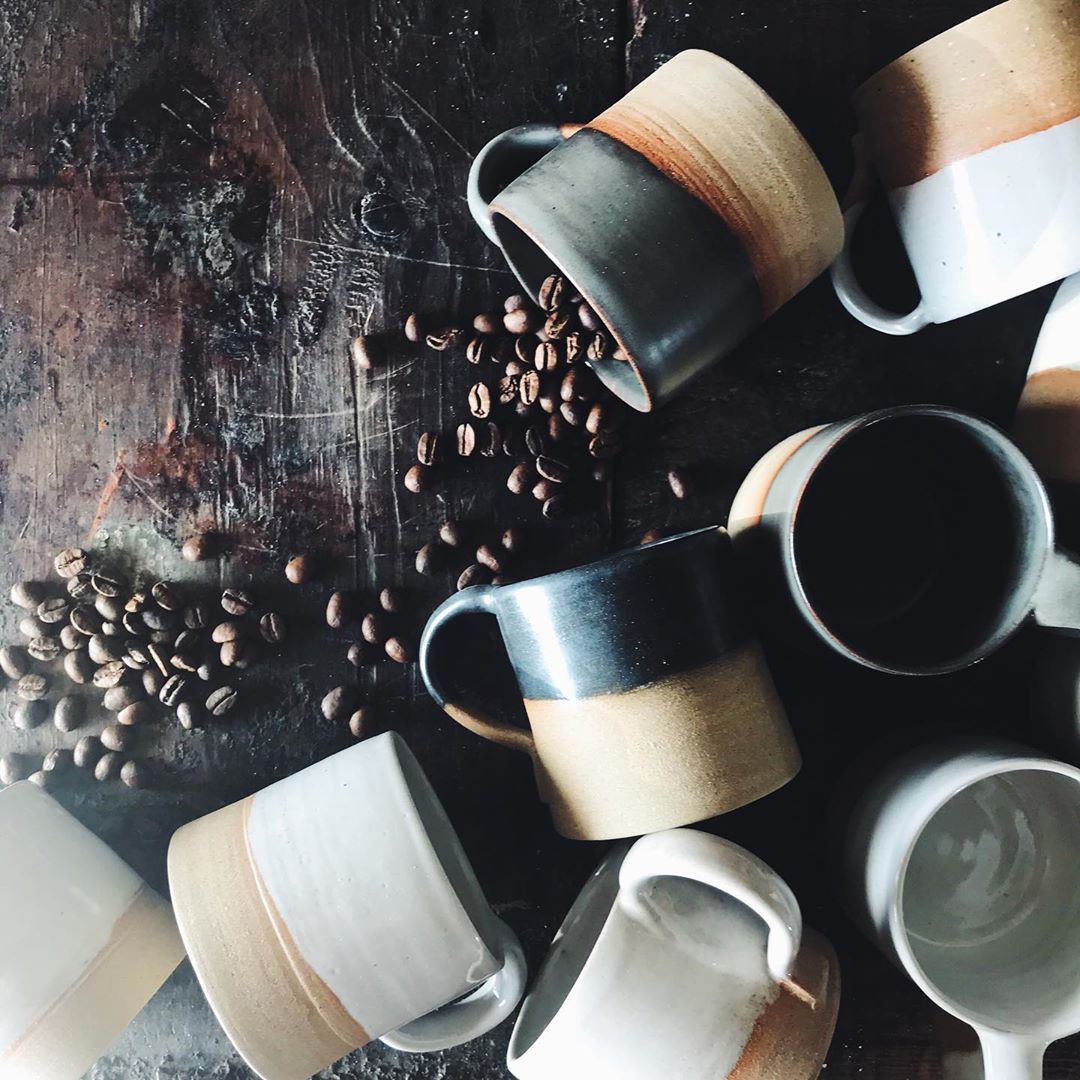

In [12]:
# Sampling Check
sample_image_path = random.choice(all_image_paths)
display.display(display.Image(sample_image_path))

In [13]:
sample_image_raw = tf.io.read_file(sample_image_path)
print('Sample Image Raw: {} ...'.format(repr(sample_image_raw)[:100]))

sample_image_tensor = tf.image.decode_jpeg(sample_image_raw, channels=3)
print('Sample Image Tensor: {}'.format(sample_image_tensor))
print('Sample Image Tensor Type: {}, Shape: {}, DataType: {}'.format(type(sample_image_tensor), sample_image_tensor.shape, sample_image_tensor.dtype))

Sample Image Raw: <tf.Tensor: id=21, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x00\x00\ ...
Sample Image Tensor: [[[ 42  47  50]
  [ 36  41  44]
  [ 33  37  40]
  ...
  [ 90  74  41]
  [ 86  70  37]
  [ 87  71  38]]

 [[ 45  50  53]
  [ 37  42  45]
  [ 42  46  49]
  ...
  [ 84  68  35]
  [ 83  67  34]
  [ 86  70  37]]

 [[ 30  35  38]
  [ 32  37  40]
  [ 46  50  53]
  ...
  [ 87  68  36]
  [ 87  68  36]
  [ 92  73  41]]

 ...

 [[251 251 251]
  [251 251 251]
  [251 251 251]
  ...
  [ 38  38  38]
  [ 32  32  32]
  [ 27  27  27]]

 [[251 251 251]
  [251 251 251]
  [251 251 251]
  ...
  [ 35  35  35]
  [ 34  34  34]
  [ 32  32  32]]

 [[251 251 251]
  [251 251 251]
  [251 251 251]
  ...
  [ 30  30  30]
  [ 34  34  34]
  [ 37  37  37]]]
Sample Image Tensor Type: <class 'tensorflow.python.framework.ops.EagerTensor'>, Shape: (1080, 1080, 3), DataType: <dtype: 'uint8'>


In [14]:
sample_image_final = tf.image.resize(sample_image_tensor, [fr, fr])
sample_image_final = (sample_image_final - 127.5) / 127.5  # Normalize the image to [-1, 1]
print('Sample Image Final: {}'.format(sample_image_final))
print('Sample Image Final Type: {}, Shape: {}, DataType: {}'.format(type(sample_image_final), sample_image_final.shape, sample_image_final.dtype))

Sample Image Final: [[[-0.5812194  -0.5719056  -0.5410233 ]
  [-0.40422794 -0.40422794 -0.38854167]
  [-0.49825367 -0.49825367 -0.49825367]
  ...
  [ 0.64231     0.50113356  0.21878064]
  [ 0.2383272   0.05009191 -0.23226103]
  [-0.08979779 -0.29568014 -0.5520527 ]]

 [[ 0.37971812  0.37971812  0.3954044 ]
  [-0.4796875  -0.4953738  -0.47184438]
  [-0.35885417 -0.37454045 -0.3666973 ]
  ...
  [ 0.61807597  0.46121323  0.18670343]
  [ 0.30625     0.11017157 -0.20355392]
  [ 0.08765319 -0.13832721 -0.40548408]]

 [[-0.30248162 -0.30248162 -0.30248162]
  [-0.5239583  -0.5553309  -0.54748774]
  [-0.3592831  -0.39065564 -0.39849877]
  ...
  [ 0.6864277   0.52172184  0.27858457]
  [ 0.51173407  0.31565565  0.00193015]
  [ 0.2999081   0.05775123 -0.28636643]]

 ...

 [[ 0.81783086  0.83351713  0.825674  ]
  [ 0.7         0.6607843   0.6137255 ]
  [ 0.74978554  0.718413    0.62429535]
  ...
  [ 0.39684436  0.43606004  0.38900122]
  [ 0.49509802  0.5264706   0.51862746]
  [-0.77205884 -0.764215

Text(0.5, 1.0, 'sample_image_final')

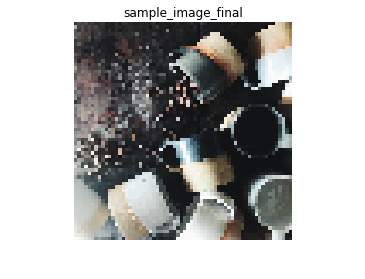

In [15]:
plt.imshow((sample_image_final + 1.0) / 2.0)  # for 'Clipping input data to the valid range for imshow with RGB data [0..1] for floats'
plt.grid(False)
plt.axis('off')
plt.xlabel(sample_image_path)
plt.title('sample_image_final')

In [16]:
def load_and_preprocess_image(path):
    raw = tf.io.read_file(path)
    tensor = tf.image.decode_jpeg(raw, channels=3)
    resized = tf.image.resize(tensor, [fr, fr])
    preprocessed = (resized - 127.5) / 127.5
    
    return preprocessed

In [17]:
path_dataset = tf.data.Dataset.from_tensor_slices(all_image_paths)
train_dataset = path_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=all_image_count).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
print('Train Dataset: {}'.format(train_dataset))

Train Dataset: <PrefetchDataset shapes: (None, 64, 64, 3), types: tf.float32>


In [18]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(q_fr * q_fr * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((q_fr, q_fr, 256)))
    assert model.output_shape == (None, q_fr, q_fr, 256)  # Note: None is the batch size
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, q_fr, q_fr, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, h_fr, h_fr, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(color_channel, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, fr, fr, color_channel)

    return model

In [19]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 65536)             6553600   
_________________________________________________________________
batch_normalization (BatchNo (None, 65536)             262144    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 65536)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0

Noise: [[-0.7380214  -0.03566767  0.34172627  0.42225274 -1.3940387  -0.30776194
  -0.8432935  -2.2530246  -1.1050454  -0.32357782 -0.31150177  0.5634213
  -0.5281189  -1.5813578   0.47414783  1.3258243  -0.8225093   0.50783664
  -1.1016383   0.2693285   1.1844226  -1.3377687   0.72329694  1.8635985
  -0.26003957  0.22080368  2.1577358   0.02573389  0.20991018  0.15375103
   2.1613982   0.07601195 -0.7606774   0.43521264  1.346152    0.47112194
   0.30716985 -1.8537809   0.7272422  -1.529545    0.86242145 -0.08726818
  -0.6905122  -0.45619583 -1.4735919   0.40411884 -1.8238775   1.781142
  -0.5561548   0.93829346 -0.08174587  0.19089045  0.45687547  0.68897855
  -0.6968298  -0.07972617  0.2779508   0.67171127 -0.74442685  0.52233416
   0.48748037 -0.0717445  -0.7788323   0.4473628  -0.5605629  -0.0876918
   0.4738279   0.9696066  -1.8298826  -0.52708864  0.8059016  -1.1075839
  -0.8857622   0.06454473  0.07499117  2.3369174   0.371934   -0.25487357
  -0.35181206  0.24702029  1.851165  

Text(0.5, 1.0, 'Noise')

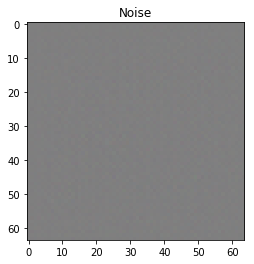

In [20]:
noise = tf.random.normal([1, noise_dim])
print('Noise: {}'.format(noise))
generated_image = generator(noise, training=False)

plt.imshow((generated_image[0, :, :, :] + 1.0) / 2.0)
plt.title('Noise')

In [21]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[fr, fr, color_channel]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [22]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)            

In [23]:
decision = discriminator(generated_image)
print('Decision: {}'.format(decision))

Decision: [[-0.00025672]]


In [24]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)

In [25]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    
    return total_loss

In [26]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [27]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [28]:
checkpoint_prefix = os.path.join(checkpoints_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [29]:
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [30]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        train_loss(disc_loss)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [31]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(8, 8))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i, :, :, :] + 1.0) / 2.0)
        plt.axis('off')

    plt.savefig(epochs_dir + '/image_{}_epoch_{:04d}.png'.format(now, epoch))
    plt.show()

In [32]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)
            history['train_loss'].append(train_loss.result())
            with train_summary_writer.as_default():
                tf.summary.scalar('train loss', train_loss.result(), step=epoch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 20 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec. Train Loss: {}'.format(epoch + 1, time.time() - start, train_loss.result()))
        plot_history()

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)
    
    # Reset metrics every epoch
    train_loss.reset_states()

In [33]:
def plot_history():
    fig = plt.figure(figsize=(12, 8))
    plt.plot(history['train_loss'])
    plt.title('History')
    plt.show()

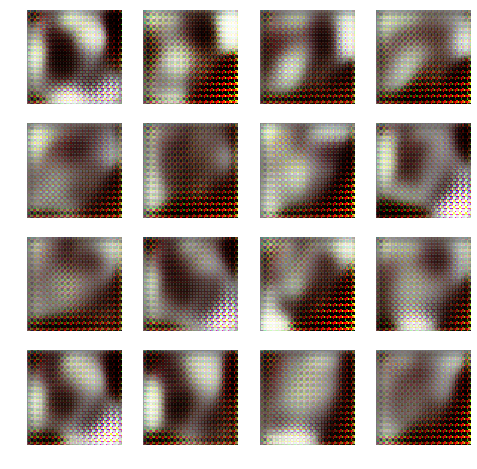

In [34]:
train(train_dataset, EPOCHS)

In [35]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoints_dir))

In [36]:
def display_image(epoch_no):
    return PIL.Image.open(epochs_dir + '/image_{}_epoch_{:04d}.png'.format(now, epoch_no))

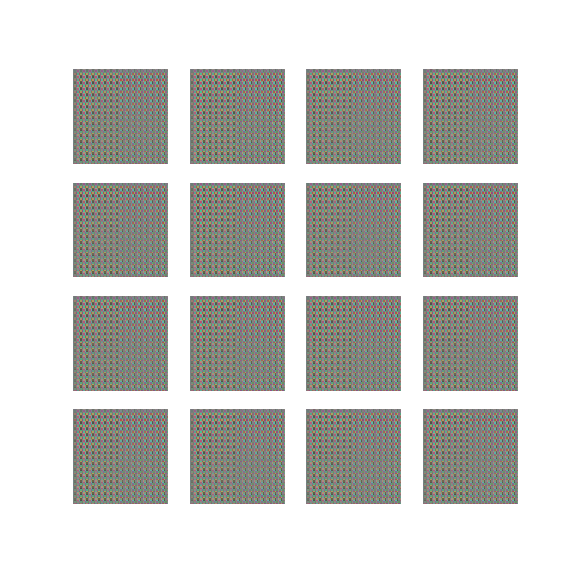

In [37]:
anim_file = gifs_dir + '/{}.gif'.format(now)

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob(epochs_dir + '/image_{}_*.png'.format(now))
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2 * (i ** 0.5)
        if round(last) < round(frame):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
    display.display(display.Image(filename=anim_file))